# Exercício-Programa 2: Resolvendo a Equação de Calor em Estado Estacionário Usando CUDA

Para este exercício-programa, será utilizado minha máquina local, um notebook com uma GPU NVIDIA GeForce GTX 1650 de 4 GB de memória.

As configurações utilizadas são:

System Details Report
---

#### Report details
- **Date generated:**                          	2024-11-04 21:17:06

#### Hardware Information:
- **Hardware Model:**                          	Acer Nitro AN515-44
- **Memory:**                                  	16,0 GiB
- **Processor:**                               	AMD Ryzen™ 7 4800H with Radeon™ Graphics × 16
- **Graphics:**                                	AMD Radeon™ Graphics
- **Graphics 1:**                              	NVIDIA GeForce GTX 1650
- **Disk Capacity:**                           	1,3 TB

#### Software Information:
- **Firmware Version:**                        	V1.04
- **OS Name:**                                 	Ubuntu 24.04.1 LTS
- **OS Build:**                                	(null)
- **OS Type:**                                 	64-bit
- **GNOME Version:**                           	46
- **Windowing System:**                        	X11
- **Kernel Version:**                          	Linux 6.8.0-48-generic

Versão do NVCC:
```console
michelly@ubuntu:~/.../exercises/07$ nvcc --version
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Fri_Jan__6_16:45:21_PST_2023
Cuda compilation tools, release 12.0, V12.0.140
Build cuda_12.0.r12.0/compiler.32267302_0
```

Para rodar os scripts python, um *virtualenv* com a versão 3.10.5 do python foi utilizada. As bibliotecas instaladas no ambiente estão no arquivo `requirements.txt`.

**Para fins de reprodutibilidade, os testes foram feitos com 1024 iterações, variando o número de pontos, threads por bloco e o número de blocos por grade. A baseline será a execução sequencial com 100 pontos e 1024 iterações.**

Detalhe dos experimentos:

- Quantidade de execuções de cada experimento: 20.

- Número de pontos testados (`n`): 50, 100, 200, 400, 800 e 1600.

- Quantidade de iterações para cada número de pontos (`i`): 10.

- Número de iterações de jacobi (fixo): `iter_limit=1024`.

- Número de threads por bloco (`t`): $x^2$, onde x = {1...i}.

- Número de blocos por grade (`b`): $\frac{(n + \sqrt{t} - 1)}{\sqrt{t}}$, onde n = {50, 100, 200, 400, 800 e 1600}.

## 1. *Parsing* dos relatórios

Essa seção do notebook realiza o *parsing* dos relatórios gerados por `run_measurements.sh`, concatena todos resultados em um único dataframe e gera o `.csv` final.

In [1]:
def get_file_paths(dir_path='measurements'):
    import os

    reports = ['jacobi_iteration.txt', 'cuda_jacobi_iteration.txt', 'cuda_jacobi_iteration_37.txt']
    
    paths = []
    for report in reports:
        paths.append(os.path.join(dir_path, report))

    return paths

In [2]:
import numpy as np
import pandas as pd
import re
import math

def parse_reports(reports):
    names = {
        'heat': 'sequential',
        'cuda_heat': 'cuda',
        'cuda_heat_37': 'cuda',
    }
    
    regex = r"\./(\w+)\.o (\d+) (\d+)(?: (\d+) (\d+))?\nTempo de execução: ([\d.]+) segundos"
    
    data = []

    for report in reports:
        match = re.match(regex, report)
        if match:
            executable, n_points, iter_limit, num_threads, num_blocks, elapsed_time = match.groups()
            block_size = int(math.sqrt(int(num_threads))) if num_threads else np.nan
            grid_dim = int(((int(n_points) + block_size - 1)/block_size)) if num_blocks else np.nan
            data.append({
                "executable": executable,
                "n_points": int(n_points),
                "iter_limit": int(iter_limit),
                "block_dim_x": block_size,
                "block_dim_y": block_size,
                "grid_dim_x": grid_dim,
                "grid_dim_y": grid_dim,
                "num_threads_per_block": int(num_threads) if num_threads else np.nan,
                "num_blocks_per_grid": int(num_blocks) if num_blocks else np.nan,
                "elapsed_time": float(elapsed_time)
            })

    df = pd.DataFrame(data)
    df['version'] = df['executable'].replace(names)

    return df

In [3]:
def read_and_parse_reports(file_paths):
    reports = ""
    for file_path in file_paths:
        f = open(file_path, 'r')
        reports += f.read()
        f.close()

    # print(reports)
    reports = reports.split("\n\n")
    df = parse_reports(reports)
    return df

In [4]:
paths = get_file_paths()
dataframes = []

dataframe = read_and_parse_reports(paths)

In [5]:
dataframe.sample(5)

,executable,n_points,iter_limit,block_dim_x,block_dim_y,grid_dim_x,grid_dim_y,num_threads_per_block,num_blocks_per_grid,elapsed_time,version
319,heat,100,1024,NaN,NaN,NaN,NaN,NaN,NaN,0.047089,sequential
45,heat,50,1024,NaN,NaN,NaN,NaN,NaN,NaN,0.008920,sequential
1176,heat,1600,1024,NaN,NaN,NaN,NaN,NaN,NaN,13.081063,sequential
1591,cuda_heat,100,1024,32.0,32.0,4.0,4.0,1024.0,16.0,0.009152,cuda
1451,cuda_heat,100,1024,2.0,2.0,50.0,50.0,4.0,2500.0,0.020281,cuda


In [6]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entries, 0 to 3599
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   executable             3600 non-null   object 
 1   n_points               3600 non-null   int64  
 2   iter_limit             3600 non-null   int64  
 3   block_dim_x            2400 non-null   float64
 4   block_dim_y            2400 non-null   float64
 5   grid_dim_x             2400 non-null   float64
 6   grid_dim_y             2400 non-null   float64
 7   num_threads_per_block  2400 non-null   float64
 8   num_blocks_per_grid    2400 non-null   float64
 9   elapsed_time           3600 non-null   float64
 10  version                3600 non-null   object 
dtypes: float64(7), int64(2), object(2)
memory usage: 309.5+ KB


In [24]:
dataframe.describe()

,n_points,iter_limit,block_dim_x,block_dim_y,grid_dim_x,grid_dim_y,num_threads_per_block,num_blocks_per_grid,elapsed_time
count,3600.000000,3600.0,2400.000000,2400.000000,2400.00000,2400.00000,2400.000000,2.400000e+03,3600.000000
mean,525.000000,1024.0,10.300000,10.300000,147.50000,147.50000,199.900000,9.290503e+04,1.313673
std,541.485407,0.0,9.687575,9.687575,266.79288,266.79288,311.259149,3.509593e+05,3.335801
min,50.000000,1024.0,1.000000,1.000000,2.00000,2.00000,1.000000,4.000000e+00,0.006921
25%,100.000000,1024.0,2.000000,2.000000,13.00000,13.00000,4.000000,1.690000e+02,0.015315
50%,300.000000,1024.0,6.500000,6.500000,50.00000,50.00000,44.500000,2.500000e+03,0.060114
75%,800.000000,1024.0,16.000000,16.000000,149.50000,149.50000,256.000000,2.238700e+04,0.602120
max,1600.000000,1024.0,32.000000,32.000000,1600.00000,1600.00000,1024.000000,2.560000e+06,16.657104


In [7]:
%%script echo skipping

dataframe.to_csv('results.csv', index=False)

skipping


## 2. Análise descritiva

In [28]:
dataframe.groupby("executable")["elapsed_time"].mean()

executable
cuda_heat       0.463228
cuda_heat_37    0.485496
heat            2.992295
Name: elapsed_time, dtype: float64

In [27]:
dataframe.groupby("executable")["elapsed_time"].median()

executable
cuda_heat       0.045496
cuda_heat_37    0.045891
heat            0.384214
Name: elapsed_time, dtype: float64

In [10]:
df_seq = dataframe[dataframe['executable'] == 'heat']
df_cuda = dataframe[dataframe['executable'] == 'cuda_heat']

In [11]:
from utils.plots import plot_mean_ci_by_exec

In [12]:
from utils.plots import plot_side_by_side

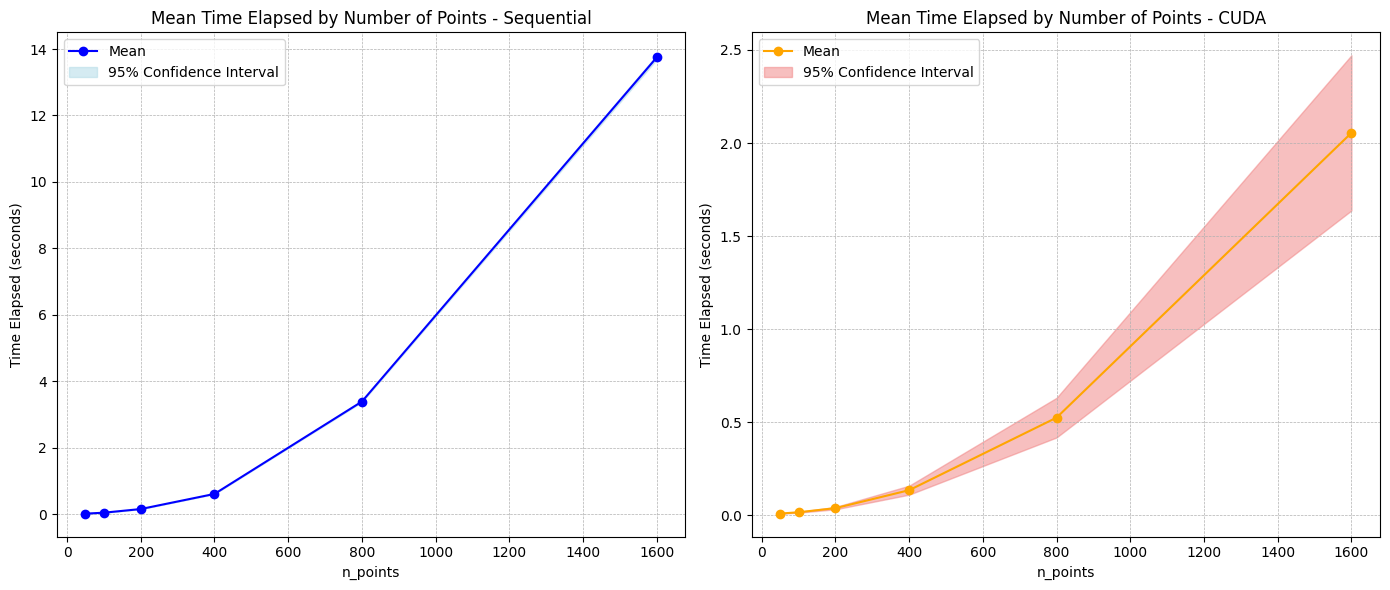

In [13]:
plot_side_by_side(df_seq, df_cuda, title1='Mean Time Elapsed by Number of Points - Sequential', title2='Mean Time Elapsed by Number of Points - CUDA', group_by="n_points")

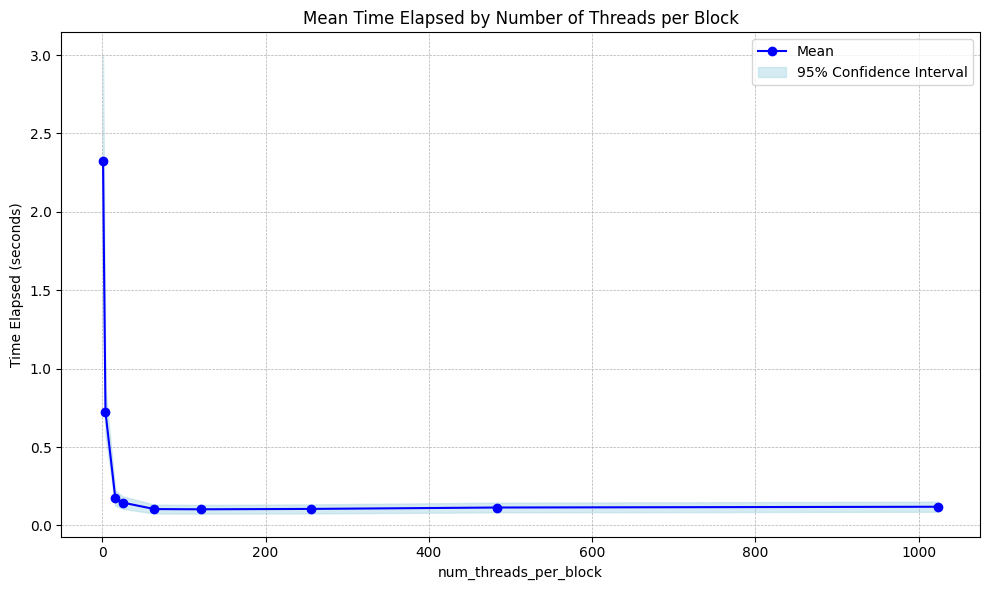

In [14]:
plot_mean_ci_by_exec(df_cuda, title="Mean Time Elapsed by Number of Threads per Block", group_by='num_threads_per_block')

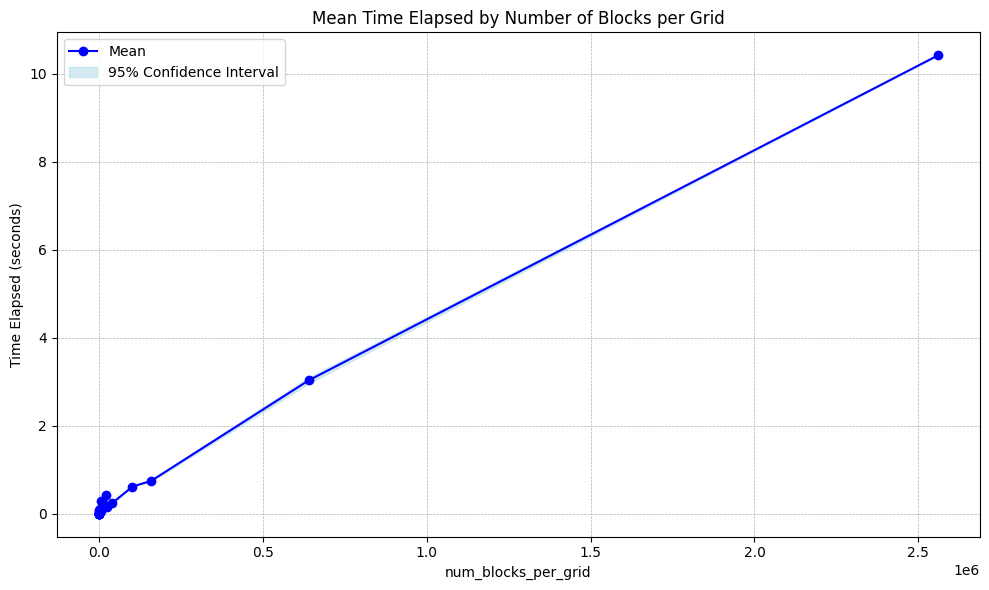

In [15]:
plot_mean_ci_by_exec(df_cuda, title="Mean Time Elapsed by Number of Blocks per Grid", group_by='num_blocks_per_grid')

### Tarefa 2 - Implementação em CUDA e cálculo do *speedup*

Logo, o speedup dessa versão para a versão sequencial foi de aproximadamente **6.6x**:

In [16]:
speedup = df_seq["elapsed_time"].mean()/df_cuda["elapsed_time"].mean()
speedup

np.float64(6.459656789242545)

#### Profiling do executável

Selecionando a melhor configuração de `t` e `b` para 100 pontos:

In [52]:
stats_1 = dataframe.loc[(dataframe['n_points'] == 100) & (dataframe['executable'] == 'cuda_heat')].groupby("num_threads_per_block")["elapsed_time"].median()
stats_1

num_threads_per_block
1.0       0.058447
4.0       0.020487
16.0      0.010450
25.0      0.009211
64.0      0.009072
121.0     0.009110
256.0     0.009163
484.0     0.009243
1024.0    0.009190
Name: elapsed_time, dtype: float64

In [53]:
stats_1.idxmin()

np.float64(64.0)

In [54]:
dataframe.loc[(dataframe['n_points'] == 100) & (dataframe['executable'] == 'cuda_heat') & (dataframe['num_threads_per_block'] == 64)].head(1)

,executable,n_points,iter_limit,block_dim_x,block_dim_y,grid_dim_x,grid_dim_y,num_threads_per_block,num_blocks_per_grid,elapsed_time,version
1500,cuda_heat,100,1024,8.0,8.0,13.0,13.0,64.0,169.0,0.009067,cuda


Logo, a melhor configuração para 100 pontos é t=64 e b=49. Realizando o profiling dos executável `cuda_heat.o`, temos:

In [59]:
%%sh
nvprof ./cuda_heat.o 100 1024 64 169 -v

==2367309== NVPROF is profiling process 2367309, command: ./cuda_heat.o 100 1024 64 169 -v
==2367309== Profiling application: ./cuda_heat.o 100 1024 64 169 -v
==2367309== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:  100.00%  4.1975ms      1024  4.0990us  2.9440us  924.50us  jacobi_iteration(double*, double*, int)
      API calls:   92.45%  161.65ms         2  80.827ms  37.715us  161.62ms  cudaMallocManaged
                    4.45%  7.7751ms      1024  7.5920us  4.1900us  929.12us  cudaDeviceSynchronize
                    2.65%  4.6332ms      1024  4.5240us  2.8630us  384.97us  cudaLaunchKernel
                    0.29%  503.91us       114  4.4200us     419ns  151.77us  cuDeviceGetAttribute
                    0.13%  234.32us         2  117.16us  50.846us  183.48us  cudaFree
                    0.01%  24.305us         1  24.305us  24.305us  24.305us  cuDeviceGetName
                    0.01%  13.829us         1  

Podemos ver que a função `jacobi_iteration` consumiu 100% do tempo de execução na GPU, como solicitado pelo relatório, com 1024 chamadas (`iter_limit`). Tendo assim:
- Tempo médio: ~4.099 µs por chamada.
- Tempo total: ~4.197 ms.

As principais chamadas de API e seus impactos no desempenho foram:

- `cudaMallocManaged`: Usou 92,45% do tempo total da CPU.
- `cudaDeviceSynchronize`: Consumiu 4,45%, sincronizando a execução entre CPU e GPU.
- `cudaLaunchKernel`: Usou 2,65% do tempo, refletindo no custo de lançamento dos kernels.

A maior parte do tempo de CPU é gasta em `cudaMallocManaged`, o que evidencia os custos associados à memória unificada.

### Tarefa 3 - Corpo Quente no Quarto

In [17]:
df_cuda_37 = dataframe[dataframe['executable'] == 'cuda_heat_37']

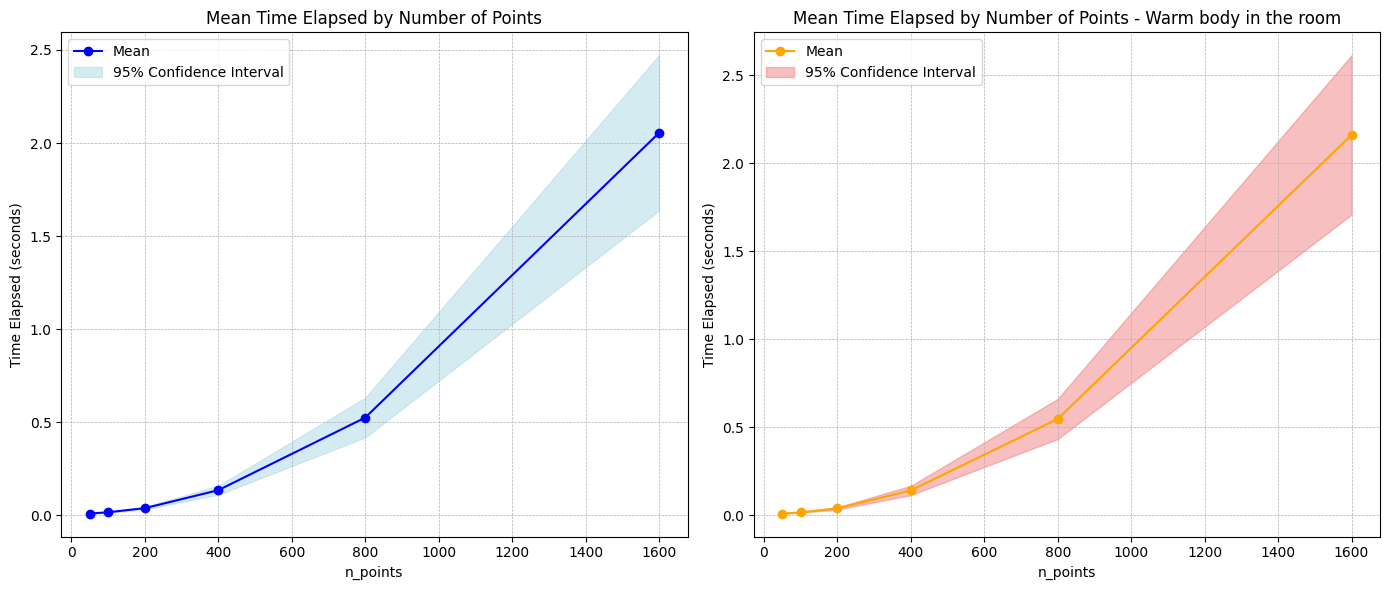

In [18]:
plot_side_by_side(df_cuda, df_cuda_37, title1='Mean Time Elapsed by Number of Points', title2='Mean Time Elapsed by Number of Points - Warm body in the room', group_by="n_points")

Calculando o `speedup` para a versão atual com a da tarefa passada:

In [85]:
speedup = df_cuda["elapsed_time"].mean()/df_cuda_37["elapsed_time"].mean()
speedup

np.float64(0.9541329119004839)

Nota-se uma ligeira degradação no desempenho no tempo de execução da versão `cuda_heat_37`.

#### Profiling do executável

Fazendo o mesmo processo de profiling para a versão da tarefa 3:

In [65]:
stats_2 = dataframe.loc[(dataframe['n_points'] == 100) & (dataframe['executable'] == 'cuda_heat_37')].groupby("num_threads_per_block")["elapsed_time"].median()
stats_2

num_threads_per_block
1.0       0.056233
4.0       0.020511
16.0      0.010589
25.0      0.009193
64.0      0.009110
121.0     0.009132
256.0     0.009168
484.0     0.009267
1024.0    0.009415
Name: elapsed_time, dtype: float64

In [66]:
stats_2.idxmin()

np.float64(64.0)

In [67]:
dataframe.loc[(dataframe['n_points'] == 100) & (dataframe['executable'] == 'cuda_heat_37') & (dataframe['num_threads_per_block'] == 64)].head(1)

,executable,n_points,iter_limit,block_dim_x,block_dim_y,grid_dim_x,grid_dim_y,num_threads_per_block,num_blocks_per_grid,elapsed_time,version
2700,cuda_heat_37,100,1024,8.0,8.0,13.0,13.0,64.0,169.0,0.009066,cuda


In [68]:
%%sh
nvprof ./cuda_heat_37.o 100 1024 64 169 -v

==2376005== NVPROF is profiling process 2376005, command: ./cuda_heat_37.o 100 1024 64 169 -v
==2376005== Profiling application: ./cuda_heat_37.o 100 1024 64 169 -v
==2376005== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:  100.00%  4.2315ms      1024  4.1320us  3.0080us  1.0325ms  jacobi_iteration(double*, double*, int)
      API calls:   92.37%  157.33ms         2  78.666ms  57.202us  157.28ms  cudaMallocManaged
                    4.33%  7.3823ms      1024  7.2090us  4.1900us  1.0331ms  cudaDeviceSynchronize
                    2.89%  4.9145ms      1024  4.7990us  3.2820us  409.14us  cudaLaunchKernel
                    0.28%  470.95us       114  4.1310us     839ns  152.12us  cuDeviceGetAttribute
                    0.11%  179.36us         2  89.678us  32.896us  146.46us  cudaFree
                    0.01%  18.648us         1  18.648us  18.648us  18.648us  cuDeviceGetName
                    0.00%  8.0320us      

Já no profiling do `cuda_heat_37`, a função `jacobi_iteration` também consumiu 100% do tempo de execução na GPU. Temos: 
- Tempo médio: ~4.132 µs por chamada.
- Tempo total: ~4.2315 ms.

As principais chamadas de API e seus impactos no desempenho foram:

- `cudaMallocManaged`: Usou 92,37% do tempo total da CPU.
- `cudaDeviceSynchronize`: Consumiu 4,33%, sincronizando a execução entre CPU e GPU.
- `cudaLaunchKernel`: Usou 2,89% do tempo, refletindo no custo de lançamento dos kernels.

Portanto, vemos que o desempenho do tempo de execução ficou bem próximo ao do `cuda_heat.o`.

### Conclusão

A análise detalhada dos experimentos revelou que, embora o desempenho da versão `cuda_heat_37.o` tenha se mantido próximo ao do `cuda_heat.o`, houve uma leve degradação no tempo total de execução. Essa diferença é perceptível tanto no tempo médio por chamada de `jacobi_iteration` quanto nos impactos das principais chamadas de API, como `cudaMallocManaged`, que continuou sendo o maior gargalo relacionado à CPU. O `profiling` reforça a necessidade de explorar estratégias mais eficientes de gerenciamento de memória, já que os custos associados à memória unificada são significativos. Apesar disso, o `speedup` geral de ~6.6x em relação à baseline sequencial confirma que ambas as versões demonstram ganhos expressivos de desempenho, validando o uso de paralelismo em CUDA para o exercício programa.